<a href="https://colab.research.google.com/github/labasubagia22/final-year-project/blob/main/_test/result_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis Kecepatan Performa pada Backend Microservices Simple Post

Tujuan dari notebook ini adalah untuk menganalisis dan memvisualisasikan hasil dari pengujian performa dari beberapa implementasi metode API Composition dan CQRS pada query relasional data dalam microservices

[Github Simple Post](https://github.com/labasubagia22/final-year-project/)

[Dokumen Skripsi](https://1drv.ms/w/s!Al2-vO5Fa1bjgxISDdA-G4McnYxp?e=kdwJlD)



## Pengantar

**Masalah**

Penelitian ini terjadi karena adanya permasalahan kompleksnya cara untuk query data relasional pada arsitektur [microservices](https://microservices.io/) karena data setiap service terpisah satu sama lain [[1]](https://docs.microsoft.com/en-us/azure/architecture/microservices/design/data-considerations). 

**Pendekatan yang Tersedia**

Ada dua metode / design pattern yang dapat digunakan untuk mengatasi permasalahan relasi data tersebut yakni:
- [API Composition](https://microservices.io/patterns/data/api-composition.html), melakukan pengambilan data di berbagai tempat lalu digabungkan

- [CQRS (Command Query Responsibility Seggregation)](https://microservices.io/patterns/data/cqrs.html), membuat sebuah service yang berisi read-only database hasil replikasi dari beberapa service 

**Tantangan**

Metode mana yang sebaiknya dipakai?

**Penelitian**

Untuk menjawab ini, dalam penelitian ini akan mencoba menemukan metode mana yang lebih baik berdasarkan kecepatan performa masing-masing metode dengan berbagai implementasi. Kecepatan performa dipilih karena dalam proses query data, hal inilah yang dapat dirasakan dan berdampak langsung pada user dan user dapat merasa apakah aplikasi itu memiliki performa yang cepat atau lambat.

**Hasil**
- Analisis Hasil Pengujian
    - Grafik Perbandingan performa dari beberapa implementasi API Composition dan CQRS
    - Alasan kenapa sebuah implementasi memiliki performa yang cepat atau lambat (faktor yang memengaruhi kecepatan performa)
- Rekomendasi implementasi

## Desain Arsitektur Backend Microservices Simple Post

Aplikasi yang akan digunakan untuk pengujian adalah aplikasi backend microservice sosial media dummy bernama **Simple Post**

![Arsitektur Simple Post](https://kroki.io/plantuml/svg/eNqFkUEOwiAQRfecYhLX9QAuvIgxDS3fSiygMGqM8e4ipa2tGleQ_2fe8IcWOyZ25HWzZ1Lao2btrBDWKZA86rKRjKu8idMZZ5AJTVl5d4AXYuelAQX4i65RHl1gWrTaYqkcM9RdECXKy4l3JVlWMoBUVWYp9RTrQXnMobUzBnbKpQGc3Rl7VPvubkKvfwyJyfzt-4Rkzfi9ls7M7rRI7hJtlAx7qG00x4WtCEYz4fJ6RG7-UdjqwLC5dEjxnyrePoyKIhamtU7V9bC3ud6leALPPbmH)

**Keterangan**

- Microservices memiliki 3 services yakni, service post, service comment, dan service query
- Implementasi API Compositoin dan CQRS akan dilakukan pada satu microservices ini

## Diagram Relasional
Pada diagram ini menggambarkan skema database yang digunakan pada beberapa service dan hubungannya secara satu sistem keseluruhan

**NOTE**: Perbedaan warna menandakan bahwa database berada di service yang berbeda
<!-- KROKI

title {label: "Simple Post Microservices Relational Diagram", size: "20"}


["svc_post.post"] {bgcolor: "#bdd6fc"}
*id
title
body


["svc_comment.comment"] {bgcolor: "#c6fcbd"}
*id
+post_id
text

["svc_query.post"] {bgcolor: "#fccdbd"}
+post_id
title
body

["svc_query.comment"] {bgcolor: "#fccdbd"}
+post_id
+comment_id
text

["svc_query.post_query"] {bgcolor: "#fccdbd"}
+post_id
title
body
comments

["svc_query.post_query.comments"] {bgcolor: "#fccdbd"}
+comment_id
text

"svc_comment.comment" *--1 "svc_post.post"
"svc_comment.comment" 1--1 "svc_query.comment" {label: "replication"}
"svc_post.post" 1--1 "svc_query.post" {label: "replication"}
"svc_query.comment" *--1 "svc_query.post"
"svc_query.post_query" 1--1 "svc_post.post" {label: "replication"}
"svc_query.post_query" 1--* "svc_query.post_query.comments" {label: "nested"}

 -->

 ![Relational Diagram](https://kroki.io/erd/svg/eNqVkj9vwjAUxHd_iiezhYJKhw6du1ZC7VhVyH5-IEtOHGyDSlG_ex0IJHWcoi75p_vdnS4OOhiCoxGSzBPwN13W8X1pfYAXjc56cnuN5OGVjAjaVsLAsxYbJ0p-B15_UaQe7vk3Y-yd-z2u6sjOmwv_gKPcoDXWRc1EKvW4xigstGKhiWXSqsOVQ1uWVIV5e09ojKxULT1t7FeNDX2GC7_dkTvkgteI6oR2WC-9D-ejh_y0FY5XOD_-p0hr6ce8LuX8qOmgVHZWKGazBSR_akS6uEp_79OdF0e10Xg6GLFC4jrgz1__gpOcImfA8lv30noVboclFgXcmL-zrMgHitP_AL2cIxE=)

**Keterangan**

Service | Warna
-- | --
Service Comment | hijau (read-write)
Service Post | biru (read-write)
Service Query | merah (read-only)

In [1]:
import json

# Contoh hasil response JSON dari query relasi
# ?limit=1

posts = [
    {
        "title": "Title 1",
        "body": "Body 1",
        "post_id": "63212e49f8bac846bbd20048",
        "comments": [
            {
                "text": "Text 1-1",
                "comment_id": "63212e4af8bac846bbd2081e"
            },
            {
                "text": "Text 1-2",
                "comment_id": "63212e4af8bac846bbd2081f"
            },
            {
                "text": "Text 1-3",
                "comment_id": "63212e4af8bac846bbd20820"
            },
            {
                "text": "Text 1-4",
                "comment_id": "63212e4af8bac846bbd20821"
            },
            {
                "text": "Text 1-5",
                "comment_id": "63212e4af8bac846bbd20822"
            },
            {
                "text": "Text 1-6",
                "comment_id": "63212e4af8bac846bbd20823"
            },
            {
                "text": "Text 1-7",
                "comment_id": "63212e4af8bac846bbd20824"
            },
            {
                "text": "Text 1-8",
                "comment_id": "63212e4af8bac846bbd20825"
            },
            {
                "text": "Text 1-9",
                "comment_id": "63212e4af8bac846bbd20826"
            },
            {
                "text": "Text 1-10",
                "comment_id": "63212e4af8bac846bbd20827"
            }
        ]
    }
]
# print(json.dumps(posts, indent=4))

## Sequence Diagram Untuk Command/Write Data pada Microservices
Pada tahap ini akan melakukan review dari masing-masing sequence diagram yang digunakan untuk implementasi write data.

**NOTE**: Metode ini merupakan metode general untuk write data

**API Composition**

![API Composition Post](https://www.websequencediagrams.com/files/render?link=jC5HznCcbMCNM3BcyqluCcmSy0mful5Zq8CtlmkH8aEV84kzuGCDpTL0I5X6kQfo)

Metode merupakan metode default untuk menyimpan data pada microservices dan implementasinya juga cukup sederhana

**CQRS**

![CQRS Post](https://www.websequencediagrams.com/files/render?link=1qLt424M0I7gbRj6kMFo9lUIyZQZbIchpcHy6TU2v8ol2pqbSA7ol1uGFwmI5xtf)

Metode ini memerlukan satu service tambahan untuk menyimpan data replikasi. Pada microservices biasanya akan menggunakan tambahan event broker untuk melakukan input data ke service replikasi. Perlu juga menerapkan sebuah metode untuk menjaga konsistensi data

## Sequence Diagram untuk Query/Read data pada Microservices
Pada tahap ini akan melakukan review dari masing-masing sequence diagram yang digunakan untuk implementasi read data relasional

**NOTE**: Untuk query data relasional ada beberapa variasi yang dapat diterapkan pada API Composition dan CQRS

**API Composition Sequential**

![API Composition Sequential](https://www.websequencediagrams.com/files/render?link=22uAoO6D84EIB5XjZgU0vbNWNCYs9axlpOmU8R9p0BxD0QQVBelhOggqxA7pGRXP)

Pada implementasi ini, setiap data hasil post akan melakukan call pada comment service secara berurutan (satu-persatu) untuk melakukan relasi data

*Kelebihan*

-  Arsitektur ini merupakan arsitektur dengan implementasi paling mudah diantara beberapa yang dibandingkan disini
- Konsistensi data terjamin karena tidak ada duplikasi data

*Kekurangan*
- Alur sirkulasi data sangat panjang karena harus ke beberapa tempat dan berulang ulang
- Implementasi ini cenderung lambat karena memerlukan request-response untuk setiap data dalam satu kali query
- Terjadi banyak request dalam sekali query (sesuai jumlah data yang berelasi)

**API Composition Parallel**

![API Composition Parallle](https://www.websequencediagrams.com/files/render?link=0r5Kx3uZZWLeHNaLGAHkJS392Uq3LYYN75o7TqfrzgjMsyZqc6nPs0fbWGmRDHdn)

Implementasi ini merupakan implementasi API Composition Sequential yang menjalankan proses request data relasi secara parallel (bersamaan), dimana ketika terjadi query, beberapa data post akan melakukan request ke comment service secara bersamaan

*Kelebihan*
- Arsitektur ini dapat memaksimalkan penggunaan CPU dan replikasi karena process yang terjadi secara bersamaan memaksimalkan penggunaan resources, sehingga tidak ada resource yang menganggur (idle)
- Konsistensi data terjamin karena tidak ada duplikasi data
- Secara konsep memiliki performa kecepatan lebih baik dibandingkan dengan API Composition Sequential

*Kekurangan*
- Kecepatan dari aristektur ini bergantung dari jumlah resource yang ada (misalnya jumlah core CPU dan replikasi server), sehingga tidak akan berpengaruh bila menggunakan resource dengan spesifikasi rendah (misal CPU single core dan server tanpa replikasi karena nantinya proses akan menjadi sequential)
- Implementasi arsitektur ini cukup kompleks karena merupakan memerlukan kemampuan pemrograman secara parallel
- Harus *berhati-hati* digunakan karena jika salah diimplementasi maka akan menyebabkan aplikasi kehabisan resource, terutama ketika diakses oleh banyak user
- Alur sirkulasi data sangat panjang karena harus ke beberapa tempat dan berulang ulang
- Terjadi banyak request dalam sekali query (sesuai jumlah data yang berelasi)

**API Composition Array**

![API Composition Array](https://www.websequencediagrams.com/files/render?link=RwTZsOI6MMTLS9LqH05Uo7vuROQB8MupFIwhpUV9hL8BDJ7Mp6IBrzKjuUQ55qZC)

Pada implementasi ini biasanya akan terjadi request sebanyak jumlah service yang terlibat dalam query relasi. Pada kasus Simple Post, ada post dan comment service yang terlibat sehingga dari API Gateway akan terjadi 2 request ke service lainnya. Selanjutnya data yang didapatkan akan digabungkan pada API Composer (pada kasus ini menggunakan API Gateway) dan biasanya memanfaatkan looping & proses looping juga biasanya berjumlah sama dengan jumlah service yang terlibat dalam proses query.

*Kelebihan*
- Jumlah request sedikit dan biasanya sesuai dengan jumlah service yang terlibat dalam satu query
- Performa cenderung lebih cepat (sampai titik tertentu) dibandingkan 2 implementasi sebelumnya karena terdapat lebih sedikit request
- Konsistensi data terjamin karena tidak ada duplikasi data

*Kekurangan*
- Biasanya perlu melakukan loop dan matching data secara manual
- Pada jumlah data yang sangat besar metode ini cenderung lebih lambat karena proses looping ketika compose data

**CQRS Single Query**

![CQRS Single Query](https://www.websequencediagrams.com/files/render?link=Ce3KGCaoZG8cvbkX5WbeNORb4sUgTkb8Wjy6014fF0Irtzy9pUobzE8Wh32egSct)

Pada implementasi ini menggunakan metode/design-pattern CQRS dimana data hanya perlu diakses di satu tempat. Metode single query ini merupakan satu metode dimana proses query hanya menggunakan satu query untuk melakukan relasi data pada. Dalam database MongoDB metode ini disebut Aggregation.

*Kelebihan*
- Alur data yang singkat, fokus pada database level
- Performa cenderung cepat karena proses query terjadi pada database level sehingga dapat menggunakan fitur-fitur yang sudah tersedia dan production-ready (seperti index)
- Output hasil query lebih mudah disesuaikan
- Performa lebih cenderung lebih cepat dari ketiga API Composition di atas

*Kekurangan*
- Tidak semua database support metode ini
- Perlu metode menangani konsistensi replikasi data
- Implementasi CQRS lebih kompleks dibandingkan API Composition

**CQRS Multiple Query**

![CQRS Multiple Query](https://www.websequencediagrams.com/files/render?link=8SJtHYx9qgsJJFZteOlmvBinb8aSrF2qHREn0CDP5Hc2jRNoIe4ACjJc4M2MBXWd)

Pada implementasi ini query database dari data berelasi akan dilakukan secara terpisah dan nantinya digabungakan (biasanya menggunakan loop). Metode ini mirip dengan API Composition Array, hanya saja pengambilan data hanya ada di satu tempat/database.

*Kelebihan*
- Database mainstream biasanya mendungkung metode ini, karena hanya melakukan query sederhana untuk pengambilan data
- Performanya diperkirakan mirip dengan API Composition Array karena metodenya yang mirip
- Alur data lebih singkat dari API Composition

*Kekurangan*
- Performa cenderung lebih lambat dari CQRS Single Query karen
- Biasanya perlu melakukan loop dan matching data secara manual
- Pada jumlah data yang sangat besar metode ini cenderung lebih lambat karena proses looping ketika compose data
- Perlu metode menangani konsistensi replikasi data
- Implementasi CQRS lebih kompleks dibandingkan API Composition

**CQRS Materialized**

![CQRS Materialized](https://www.websequencediagrams.com/files/render?link=VNvIitQGXDmptEM9gnTBfM9fGS2ojWdOt1CwYpDMv7GftYbRJD7VbKblMGXhNWzh)

Pada implementasi ini, pengambilan data hanya terjadi dalam satu request dan tidak perlu melakukan query yang rumit karena data sudah beberbentuk seperti apa yang diinginkan. Ini seperti kita melakukan pemanggilan pada plain data JSON. Karena itulah metode ini memiliki performa cepat

*Kelebihan*
- Performa sangat cepat
- Alur query data paling singkat  diantara metode yang dibandingkan

*Kekurangan*
- Implementasi yang paling kompleks diantara semua metode yang dibandingkan
- Perlu penanganan khusus untuk menjaga konsistensi dan bentuk data
- Perlu penanganan race condition saat replikasi data (terutama field mana yang jadi parent dan child)
- Kurang fleksibel ketika ada perubahan shape data yang diperlukan
- Tidak didukung semua jenis database, karena biasanya memerlukan nested data

## Rank Tingkat Kesulitan/Kompleksitas saat melakukan Implementasi/Coding

Tabel berikut menunjukan tingkat kesulitan dari implementasi-implementasi API Composition dan CQRS

Rangking diurutkan dari yang tersulit ke termudah


Implementasi | Argumen
--- | ---
CQRS Materialized | - Kompleksitas arsitektur pada saat write data karena memerlukan event broker
    | - Perlu handle masalah konsistensi data
    | - Perlunya handle race condition pada case tertentu
    | - Kadang memerlukan database khusus agar sesuai dengan bentuk data yang disimpan
    | - Perubahan skema data sangat merepotkan karena data sudah sesuai query sebelumnya
CQRS Multiple Query | - Kompleksitas arsitektur pada saat write data karena memerlukan event broker
    | - Perlu handle masalah konsistensi data
    | - Loop untuk handling data perlu dibuat efisien
    | - Perlu berhati-hati ketika menggunakan database ORM/ODM karena berpengaruh pada performa compose data
CQRS Single Query | - Kompleksitas arsitektur pada saat write data karena memerlukan event broker
    | - Perlu handle masalah konsistensi data
    | - Tidak semua database support untuk single query
API Composition Parallel | - Implementasi parallel programming memang kompleks
    | - Perlu memastikan agar resource tidak habis dan sesuai dengan proses yang berjalan parallel agar aplikasi tidak down
API Composition Array | - Loop untuk handling compose data perlu dibuat efisien
API Composition Sequential | - Implementasi paling mudah karena hanya request dan loop biasa




## Rank Tingkat Kompleksitas Flow Data Pada Implementasi Saat Melakukan Query Data
Tabel berikut menunjukan tingkat kompleksitas flow data dari implementasi-implementasi API Composition dan CQRS

Rangking diurutkan dari yang terkompleks ke yang tidak kompleks

Implementasi | Argumen
--- | ---
API Composition Sequential | - Loop Setiap item pada data perlu melakukan request ke service untuk melakukan relasi dan harus dilakukan berurutan (menunggu)
    | - Interaksi ke beberapa service
API Composition Parallel | - Loop Setiap item pada data perlu melakukan request ke service untuk melakukan relasi namun dapat dilakukan secara bersamaan (parallel)
    | - Interaksi ke beberapa service
API Composition Array | - Jumlah request bergantung pada service yang terlibat dalam satu query 
    | - Looping untuk compose data biasanya dapat memiliki kompleksitas O=n^m. Dimana n=n_data, m=n_service
    | - Interaksi ke beberapa service
CQRS Multiple Query | - Jumlah query dapat berjumlah tergantung berapa banyak tabel yang ikut berelasi
    | - Looping untuk compose data biasanya dapat memiliki kompleksitas O=n^t. Dimana n=n_data, t=n_tabel
    | - Interaksi ke satu service
CQRS Single Query | - Query data hanya sekali dan di level database (kompleks query)
    | - Interaksi ke satu service
CQRS Materialized | - Query sederhana ke database (seperti get data JSON saja) karena data sudah berbentuk sesuai yang diinginkan
    | - Interaksi ke satu service

**NOTE**: Setiap size data bertambah maka waktu untuk pengiriman baik antar service, database, atau client pasti bertambah 



## Import Library yang Diperlukan Untuk Analisis

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

In [3]:
os.system('apt-get install -y tree')

0

## Analisis Hasil Pengujian

### Konfigurasi

- Jangan centang **is_author** jika anda bukan pemilik notebook ini karena ini digunakan untuk akses file hasil pengujian

In [4]:
# Check this if you're the outhor of this notebook
is_author = True #@param {type:"boolean"}

# Other config
plot_title_args = {'fontsize': 14, 'fontweight': 'bold'}

### Konstanta

In [5]:
# Keys
KEY_API_COMPOSITION_SEQUENTIAL = 'ACS'
KEY_API_COMPOSITION_PARALLEL = 'ACP'
KEY_API_COMPOSITION_ARRAY = 'ACA'
KEY_CQRS_SINGLE_QUERY = 'CSQ'
KEY_CQRS_MULTIPLE_QUERY = 'CMQ'
KEY_CQRS_MATERIALIZED = 'CM'

# Predict Types
PREDICT_LINEAR = 'linear'
PREDICT_POLY = 'polynomial'

In [6]:
# Map Result
RESULT_MAP = {
    KEY_API_COMPOSITION_SEQUENTIAL: {
        'name': 'API Composition Sequential',
        'file': 'api_comp_seq.csv',
        'color': 'blue',
        'url_path': 'posts-api-comp-sequential',
        'predict_type': PREDICT_LINEAR,
    },
    KEY_API_COMPOSITION_PARALLEL: {
        'name': 'API Composition Parallel',
        'file': 'api_comp_par.csv',
        'color': 'green',
        'url_path': 'posts-api-comp-parallel',
        'predict_type': PREDICT_LINEAR,
    },
    KEY_API_COMPOSITION_ARRAY: {
        'name': 'API Composition Array',
        'file': 'api_comp_arr.csv',
        'color': 'red',
        'url_path': 'posts-api-comp-id-array',
        'predict_type': PREDICT_POLY,
    },
    KEY_CQRS_SINGLE_QUERY: {
        'name': 'CQRS Single Query',
        'file': 'cqrs_single.csv',
        'color': 'black',
        'url_path': 'posts-cqrs-query-agg',
        'predict_type': PREDICT_LINEAR,
    },
    KEY_CQRS_MULTIPLE_QUERY: {
        'name': 'CQRS Multiple Query',
        'file': 'cqrs_multi.csv',
        'color': 'orange',
        'url_path': 'posts-cqrs-query-manual',
        'predict_type': PREDICT_POLY,
    },
    KEY_CQRS_MATERIALIZED: {
        'name': 'CQRS Materialized',
        'file': 'cqrs_mat.csv',
        'color': 'purple',
        'url_path': 'posts-cqrs-materialize',
        'predict_type': PREDICT_LINEAR,
    },
}

### Load Hasil Pengujian

In [7]:
RESULT_PATH = '/content/result'
DATASET_PATH = '/content/dataset'

folders = [
    {'id': '1ZC7kunkD5bYJ65zsV0kFWDYHPSQxSneI', 'name': 'result'},
    {'id': '1Z7er2w8iRA0XzrL6dK7ZRvAZ8hKxlPQy', 'name': 'dataset'},
]

if is_author:
    drive.mount('/content/drive')
    for folder in folders:
        os.system(f'ln -s /content/drive/MyDrive/kuliah/skripsi/test_locust/{folder["name"]}/ /content/')
else:
    for folder in folders:
        os.system(f'gdown -q https://drive.google.com/drive/folders/{folder["id"]} -O $RESULT_PATH --folder')

Mounted at /content/drive


### Fungsi Preproses Hasil Pengujian




In [8]:
LOCUST_RESULT_COLUMNS = {
    'Request Count': 'sample',
    'Data Size': 'data_size',
    'Average Response Time': 'avg',
    'Min Response Time': 'min',
    'Max Response Time': 'max',
}

def get_locust_result_df(file_path):
    df = pd.read_csv(file_path)
    # remove last row
    df = df.iloc[:-1, :]
    # df = df[df['Failure Count'] == 0]

    # add data size
    df['Data Size'] = df['Name'].apply(lambda x: int(x.split('limit=')[1]))

    # sort by data size
    df = df.sort_values(by=['Data Size'])

    # select columns
    columns = LOCUST_RESULT_COLUMNS
    df = df[columns.keys()]
    df.rename(columns=columns, inplace=True)
    df.reset_index(inplace=True)

    return  df

def get_step_df(step_dir):
    df = pd.DataFrame()
    for key, value in RESULT_MAP.items():
        result_file = os.path.join(step_dir, value['file'])
        if os.path.exists(result_file):
            file_df = get_locust_result_df(result_file)
            if (not 'sample' in df.columns) or df['sample'].mean() > file_df['sample'].mean():
                df['sample'] = file_df['sample']
            df['data_size'] = file_df['data_size']
            df[key] = file_df['avg']
    return df

def get_locust_dataset_df(dataset_path):
    dataset_df = pd.read_csv(dataset_path)
    dataset_df = dataset_df.iloc[:-1, :]
    # dataset_df = dataset_df[dataset_df['Failure Count'] == 0]
    dataset_df['Data Size'] = dataset_df['Name'].apply(lambda x: int(x.split('limit=')[1]))
    dataset_df.rename(columns=LOCUST_RESULT_COLUMNS, inplace=True)

    df = pd.DataFrame()
    for key, req_type in RESULT_MAP.items():
        req_df = dataset_df[dataset_df['Name'].str.contains(req_type['url_path'])]
        if not req_df.empty:
            req_df = req_df.sort_values(by=['data_size'])
            req_df = req_df.reset_index(drop=True)
            df[key] = req_df['avg']
            df[f'url_{key}'] = req_df['Name']
            if not 'data_size' in df.columns:
                df['data_size'] = req_df['data_size']

    df.reset_index(drop=True, inplace=True)
    return df

def map_result_path_df(dir=RESULT_PATH):
    map = {}
    server_types = [x for x in os.listdir(dir) if 'skip' not in x]
    for server in sorted(server_types):
        map[server] = {}
        steps = [x for x in os.listdir(os.path.join(dir, server)) if 'skip' not in x]
        for step in steps:
            step_dir = os.path.join(dir, server, step) 
            map[server][step] = get_step_df(step_dir)
    return map

### Fungsi Visualisasi Hasil Pengujian

In [9]:
PLOT_COLUMNS = [
    KEY_API_COMPOSITION_SEQUENTIAL, 
    KEY_API_COMPOSITION_PARALLEL,
    KEY_API_COMPOSITION_ARRAY,
    KEY_CQRS_SINGLE_QUERY,
    KEY_CQRS_MULTIPLE_QUERY,
    KEY_CQRS_MATERIALIZED
]

def show_result_plot(df, title='', figsize=(8, 6), columns=PLOT_COLUMNS,):
    plt.figure(figsize=figsize)
    for column in columns:
        if column in df.columns:
            m = RESULT_MAP[column]
            plt.plot(df['data_size'], df[column], color=m['color'], label = f"{m['name']} ({column})")
    plt.title(title, **plot_title_args, y=1.04)
    plt.xlabel('data size')
    plt.ylabel('avg response time (ms)')
    plt.legend()
    plt.show()


def visualize_result_path(result_path, configs={}):
    map = map_result_path_df(result_path)
    
    for server, steps in map.items():
        for step, df in sorted(steps.items()):
            if df.empty:
                continue
            default_columns = ['sample','data_size']
            if server in configs and step in configs[server]:
                for i, cfg in enumerate(configs[server][step]):
                    conf_df = df.copy()
                    if 'limit' in cfg:
                        lim = cfg['limit']
                        conf_df = conf_df.iloc[lim.get('start', 0):lim.get('end', conf_df.shape[0])]
                    show_result_plot(conf_df, title=f'{server} {step}.{i+1}', columns=cfg['cols'])
    
                    if 'desc' in cfg:
                        print(cfg['desc'], '\n')

                    columns = [x for x in (default_columns+cfg['cols']) if x in df.columns]
                    print(df[columns].to_string(), '\n')
            else:
                columns = [x for x in (default_columns+PLOT_COLUMNS) if x in df.columns]
                show_result_plot(df, title=f'{server} {step}')
                print(df[columns].to_string())
                print()
        print()

### Visualisasi Grafik Hasil Pengujian
Berikut adalah Grafik Perbandingan dari variasi implementasi API Composition dan CQRS beserta argumennya


In [10]:
# Show
!tree $RESULT_PATH -d -I '*skip*'

/content/result
├── 1.local_4cpu_8g-ram
│   ├── step1
│   ├── step2
│   ├── step3
│   └── step4
└── 2.gcp_2cpu_2g-ram
    ├── step1
    ├── step2
    └── step3

9 directories


Dalam test ini, semakin kecil response-time maka semakin cepat performanya


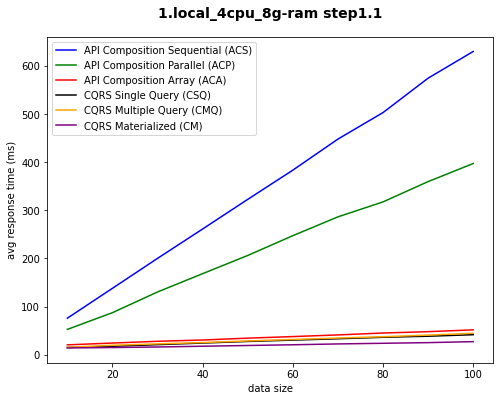

Tampilkan semua implementasi

Performa dari ['ACS', 'ACP'] menurun signifikan dibandigkan yang lain
Hal ini karena banyaknya request yang terjadi pada satu query relasional
ACP memiliki performa lebih baik karena berjalan secara parallel 

   sample  data_size         ACS         ACP        ACA        CSQ        CMQ         CM
0     100         10   75.904645   52.616997  20.492875  15.082091  15.447175  14.007806
1     100         20  137.996288   87.374696  24.227868  17.530400  19.671427  14.945136
2     100         30  200.185471  130.374892  27.922353  20.932291  22.545285  16.047059
3     100         40  261.184303  168.387804  30.558537  24.239959  25.290573  17.648627
4     100         50  322.745595  206.199615  34.438308  27.543438  28.623860  19.170676
5     100         60  383.400630  247.284760  37.690001  30.347612  31.663497  20.658179
6     100         70  447.938921  286.370785  41.140425  33.143809  34.665632  22.401889
7     100         80  502.987578  317.459535  45

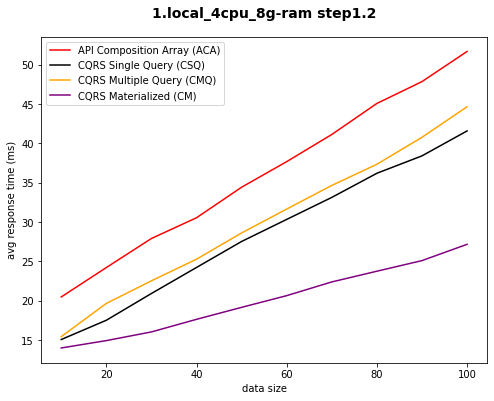

Detail implementasi ['ACA', 'CSQ', 'CMQ', 'CM']

Performa ACA lebih lambat dari CMQ, karena perlu request data ke service lain
Performa CSQ lebih baik dari CMQ karena hanya perlu melakukan satu query database 

   sample  data_size        ACA        CSQ        CMQ         CM
0     100         10  20.492875  15.082091  15.447175  14.007806
1     100         20  24.227868  17.530400  19.671427  14.945136
2     100         30  27.922353  20.932291  22.545285  16.047059
3     100         40  30.558537  24.239959  25.290573  17.648627
4     100         50  34.438308  27.543438  28.623860  19.170676
5     100         60  37.690001  30.347612  31.663497  20.658179
6     100         70  41.140425  33.143809  34.665632  22.401889
7     100         80  45.084205  36.209366  37.355161  23.762552
8     100         90  47.860924  38.422400  40.780131  25.110558
9     100        100  51.691116  41.590090  44.666472  27.180805 



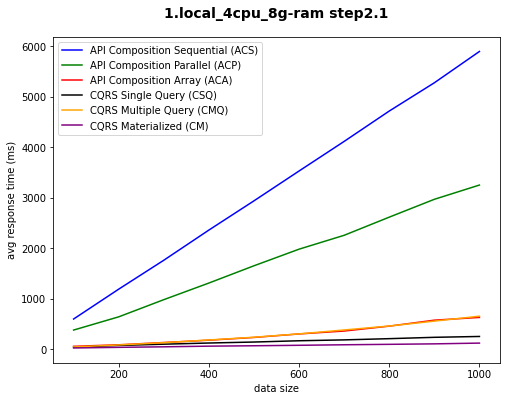

Tampilkan semua implementasi 

   sample  data_size          ACS          ACP         ACA         CSQ         CMQ          CM
0     100        100   597.914195   379.230101   57.388164   41.309987   45.668840   24.644277
1     100        200  1188.953734   640.936855   87.854374   74.727276   83.970194   37.262648
2     100        300  1761.202018   980.841673  132.788063   99.576476  129.178028   47.733158
3     100        400  2358.512973  1310.063603  178.856103  122.820182  183.106369   60.626466
4     100        500  2937.158540  1651.632825  232.844572  142.222769  237.106020   68.418170
5     100        600  3527.784040  1980.354300  302.560739  167.583379  303.634063   77.793561
6     100        700  4113.425361  2254.971579  359.951190  184.805357  380.923159   88.128502
7     100        800  4714.381778  2614.162708  456.840049  208.947755  459.473138   96.687610
8     100        900  5273.795559  2967.349897  575.064528  235.607046  556.233325  106.237490
9     100       100

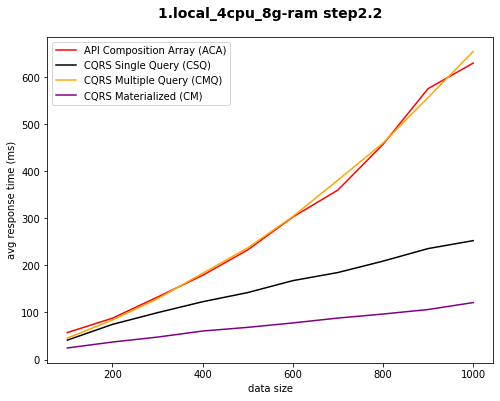

Detail implementasi ['ACA', 'CSQ', 'CMQ', 'CM']
Dapat dilihat bahwa ACA dan CMQ mulai naik, karena iterasi pada loop semakin tinggi 

   sample  data_size         ACA         CSQ         CMQ          CM
0     100        100   57.388164   41.309987   45.668840   24.644277
1     100        200   87.854374   74.727276   83.970194   37.262648
2     100        300  132.788063   99.576476  129.178028   47.733158
3     100        400  178.856103  122.820182  183.106369   60.626466
4     100        500  232.844572  142.222769  237.106020   68.418170
5     100        600  302.560739  167.583379  303.634063   77.793561
6     100        700  359.951190  184.805357  380.923159   88.128502
7     100        800  456.840049  208.947755  459.473138   96.687610
8     100        900  575.064528  235.607046  556.233325  106.237490
9     100       1000  629.334445  252.468849  654.003228  121.025227 



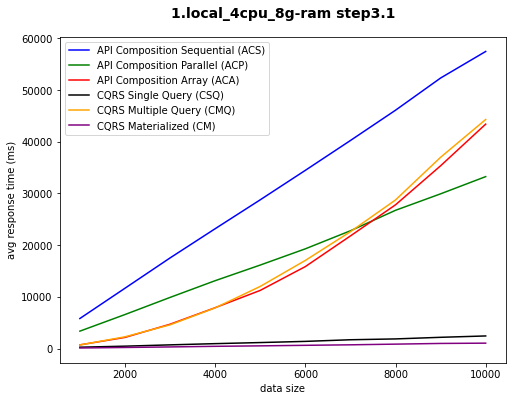

Tampilkan semua implementasi 

   sample  data_size           ACS           ACP           ACA          CSQ           CMQ           CM
0      10       1000   5822.246090   3380.241943    728.474906   278.932305    702.332302   127.820021
1      10       2000  11669.445230   6588.056980   2166.939895   476.387949   2284.071602   224.811243
2      10       3000  17528.132501   9897.696642   4716.732280   729.890484   4597.430965   329.073478
3      10       4000  23172.559406  13129.149233   7913.647132   964.800326   7872.615207   447.483460
4      10       5000  28761.315405  16152.015632  11254.886114  1174.133527  12021.735289   536.314209
5      10       6000  34454.503632  19287.472582  15854.760377  1401.073290  17042.948102   641.462802
6      10       7000  40221.387174  22778.107040  21779.127059  1717.345128  22598.973201   738.856695
7      10       8000  46073.675087  26733.045945  27790.405619  1877.749688  28729.918398   870.068805
8      10       9000  52297.024385  29916.

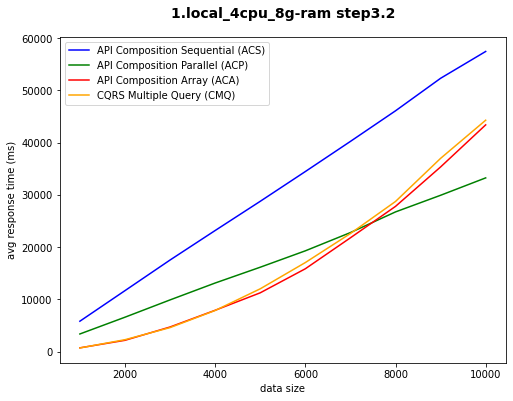

Detail implementasi ['ACS', 'ACP', 'ACA', 'CMQ']
ACA dan CMQ naik signifikan dan melampaui ACP. 

   sample  data_size           ACS           ACP           ACA           CMQ
0      10       1000   5822.246090   3380.241943    728.474906    702.332302
1      10       2000  11669.445230   6588.056980   2166.939895   2284.071602
2      10       3000  17528.132501   9897.696642   4716.732280   4597.430965
3      10       4000  23172.559406  13129.149233   7913.647132   7872.615207
4      10       5000  28761.315405  16152.015632  11254.886114  12021.735289
5      10       6000  34454.503632  19287.472582  15854.760377  17042.948102
6      10       7000  40221.387174  22778.107040  21779.127059  22598.973201
7      10       8000  46073.675087  26733.045945  27790.405619  28729.918398
8      10       9000  52297.024385  29916.086159  35335.580909  36978.084511
9      10      10000  57428.818639  33243.183044  43386.279270  44278.274882 



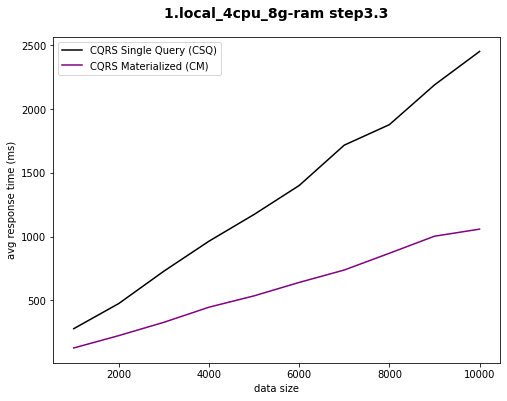

Detail implementasi ['CSQ', 'CM']
CSQ dan CM memiliki performa terbaik (semakin kecil semakin bagus) 

   sample  data_size          CSQ           CM
0      10       1000   278.932305   127.820021
1      10       2000   476.387949   224.811243
2      10       3000   729.890484   329.073478
3      10       4000   964.800326   447.483460
4      10       5000  1174.133527   536.314209
5      10       6000  1401.073290   641.462802
6      10       7000  1717.345128   738.856695
7      10       8000  1877.749688   870.068805
8      10       9000  2189.024264  1003.627935
9      10      10000  2451.305228  1058.960288 



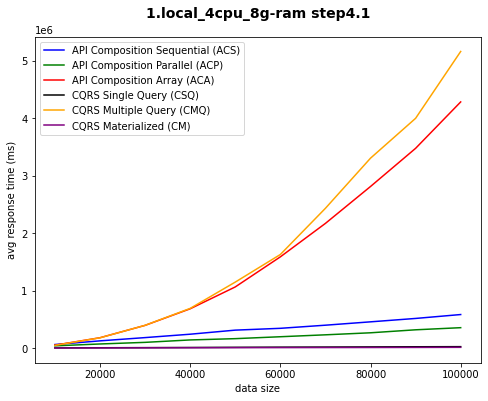

Tampilkan semua implementasi 

   sample  data_size            ACS            ACP           ACA           CSQ           CMQ            CM
0       1      10000   61082.215092   38477.848302  5.009205e+04   2449.935573  4.675677e+04   1195.083519
1       1      20000  125080.316412   70770.173677  1.794052e+05   4989.420256  1.779753e+05   2298.728045
2       1      30000  181652.339122   98904.772599  3.943468e+05   7117.676773  3.953062e+05   3645.193978
3       1      40000  240735.325989  141003.039166  6.828874e+05   9795.239468  6.896887e+05   4611.207077
4       1      50000  311641.900588  163408.158616  1.063272e+06  12673.978302  1.147389e+06   6231.578491
5       1      60000  343319.495710  196706.547231  1.586702e+06  15277.334634  1.627660e+06   7578.716196
6       1      70000  397608.510753  230224.336486  2.169293e+06  17245.405842  2.431875e+06   8484.144719
7       1      80000  456097.416505  265439.329156  2.811411e+06  19731.496050  3.304305e+06   9373.113258
8     

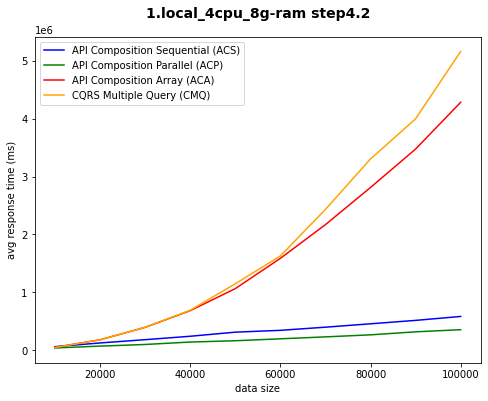

Detail implementasi ['ACS', 'ACP', 'ACA', 'CMQ']

ACA dan CMQ respon time tumbuh secara cepat melampaui semuanya

CMQ Mulai melampaui ACA secara stabil pada data_size > 6000
Hal ini karena pada CMQ, driver database perlu memformat beberapa tipe data seperti ObjectID sehingga membuat proses lebih lambat 

   sample  data_size            ACS            ACP           ACA           CMQ
0       1      10000   61082.215092   38477.848302  5.009205e+04  4.675677e+04
1       1      20000  125080.316412   70770.173677  1.794052e+05  1.779753e+05
2       1      30000  181652.339122   98904.772599  3.943468e+05  3.953062e+05
3       1      40000  240735.325989  141003.039166  6.828874e+05  6.896887e+05
4       1      50000  311641.900588  163408.158616  1.063272e+06  1.147389e+06
5       1      60000  343319.495710  196706.547231  1.586702e+06  1.627660e+06
6       1      70000  397608.510753  230224.336486  2.169293e+06  2.431875e+06
7       1      80000  456097.416505  265439.329156  2.811411e+

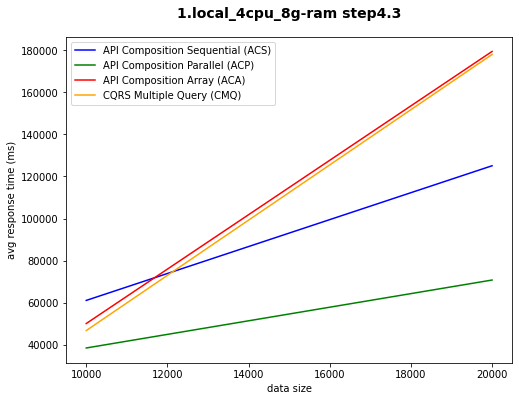

ACA dan CMQ melampaui semuanya

Hal ini diakibatkan oleh penggunaan loop pada compose data

Berbeda dengan ['ACS', 'ACP'], meski juga menggunakan loop, namun juga ada kontirbusi indexing pada databse pada saat mencari data 

   sample  data_size            ACS            ACP           ACA           CMQ
0       1      10000   61082.215092   38477.848302  5.009205e+04  4.675677e+04
1       1      20000  125080.316412   70770.173677  1.794052e+05  1.779753e+05
2       1      30000  181652.339122   98904.772599  3.943468e+05  3.953062e+05
3       1      40000  240735.325989  141003.039166  6.828874e+05  6.896887e+05
4       1      50000  311641.900588  163408.158616  1.063272e+06  1.147389e+06
5       1      60000  343319.495710  196706.547231  1.586702e+06  1.627660e+06
6       1      70000  397608.510753  230224.336486  2.169293e+06  2.431875e+06
7       1      80000  456097.416505  265439.329156  2.811411e+06  3.304305e+06
8       1      90000  515143.474761  317490.046606  3.475776e+06

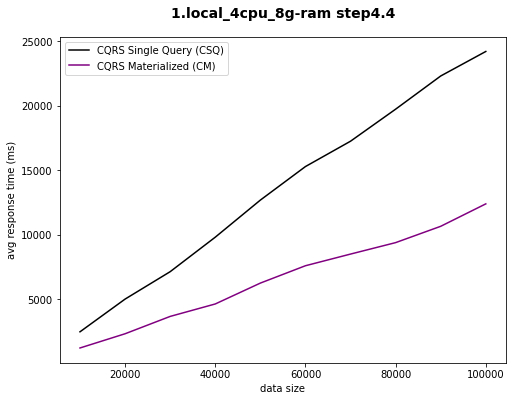

Datail implementasi ['CSQ', 'CM']
CSQ dan CM masih menjadi yang terbaik 

   sample  data_size           CSQ            CM
0       1      10000   2449.935573   1195.083519
1       1      20000   4989.420256   2298.728045
2       1      30000   7117.676773   3645.193978
3       1      40000   9795.239468   4611.207077
4       1      50000  12673.978302   6231.578491
5       1      60000  15277.334634   7578.716196
6       1      70000  17245.405842   8484.144719
7       1      80000  19731.496050   9373.113258
8       1      90000  22308.198836  10639.941046
9       1     100000  24210.909971  12381.856208 




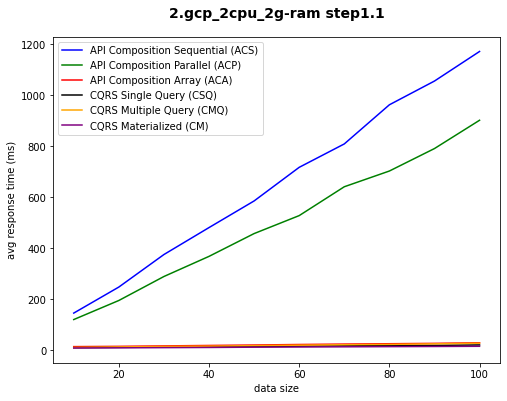

Tampilkan semua implementasi

Performa dari ['ACS', 'ACP'] menurun signifikan dibandigkan yang lain
Hal ini karena banyaknya request yang terjadi pada satu query relasional
ACP memiliki performa lebih baik karena berjalan secara parallel 

   sample  data_size          ACS         ACP        ACA        CSQ        CMQ         CM
0     100         10   144.685741  119.291198  13.049802   8.872749   9.713593   7.687346
1     100         20   246.957545  194.190100  14.046678  10.121527  11.941881   8.193969
2     100         30   374.690593  288.387813  15.831839  11.041015  13.577473   9.016777
3     100         40   480.546414  367.453236  17.554009  12.415014  14.863466   9.690941
4     100         50   585.118894  456.977278  19.289876  13.555260  16.899278  10.782514
5     100         60   717.154971  527.566331  21.356758  14.720473  18.671804  11.483009
6     100         70   809.063171  640.878722  23.001979  16.097044  20.450517  12.274045
7     100         80   962.764598  702.6

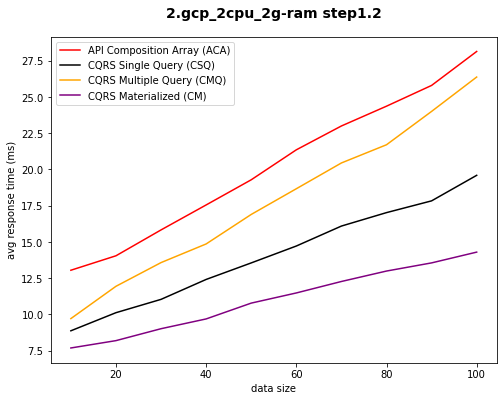

Detail implementasi ['ACA', 'CSQ', 'CMQ', 'CM']

Performa ACA lebih lambat dari CMQ, karena perlu request data ke service lain
Performa CSQ lebih baik dari CMQ karena hanya perlu melakukan satu query database 

   sample  data_size        ACA        CSQ        CMQ         CM
0     100         10  13.049802   8.872749   9.713593   7.687346
1     100         20  14.046678  10.121527  11.941881   8.193969
2     100         30  15.831839  11.041015  13.577473   9.016777
3     100         40  17.554009  12.415014  14.863466   9.690941
4     100         50  19.289876  13.555260  16.899278  10.782514
5     100         60  21.356758  14.720473  18.671804  11.483009
6     100         70  23.001979  16.097044  20.450517  12.274045
7     100         80  24.366845  17.024707  21.706196  12.994011
8     100         90  25.799356  17.835848  24.006889  13.556687
9     100        100  28.141492  19.597314  26.377457  14.299876 



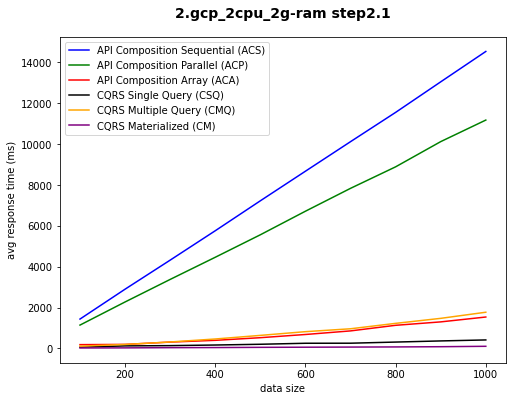

Tampilkan semua implementasi 

   sample  data_size           ACS           ACP          ACA         CSQ          CMQ          CM
0     100        100   1434.001836   1139.145467   181.937266   56.307121   108.134844   18.513155
1     100        200   2897.591988   2271.764909   193.668551  120.105262   190.174225   23.313039
2     100        300   4320.232315   3375.494567   307.067288  133.632519   312.295624   33.800819
3     100        400   5759.171999   4460.403423   392.743551  163.330163   458.637448   38.432362
4     100        500   7225.797609   5561.691436   522.206910  200.299479   635.097021   49.270386
5     100        600   8674.768631   6715.641927   678.771503  249.338535   817.367643   56.138552
6     100        700  10120.991879   7835.430839   854.478734  252.132940   958.970768   62.850922
7     100        800  11554.737015   8888.752171  1128.702054  307.654968  1224.158449   69.586081
8     100        900  13050.640193  10122.894784  1295.946900  363.724351  146

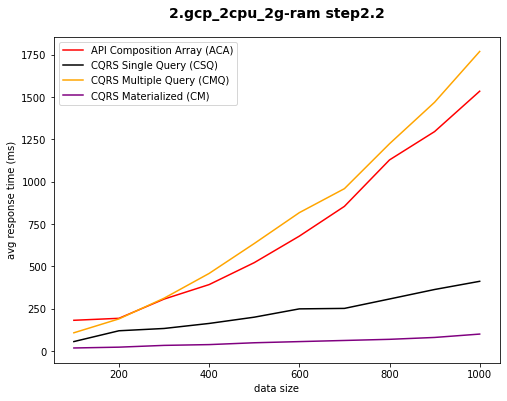

Detail implementasi ['ACA', 'CSQ', 'CMQ', 'CM']
Dapat dilihat bahwa ACA dan CMQ mulai naik, karena iterasi pada loop semakin tinggi
CMQ juga mulai melampaui ACA akibat pengolahan langsung pada data hasil dari driver database (cost of abstraction) 

   sample  data_size          ACA         CSQ          CMQ          CM
0     100        100   181.937266   56.307121   108.134844   18.513155
1     100        200   193.668551  120.105262   190.174225   23.313039
2     100        300   307.067288  133.632519   312.295624   33.800819
3     100        400   392.743551  163.330163   458.637448   38.432362
4     100        500   522.206910  200.299479   635.097021   49.270386
5     100        600   678.771503  249.338535   817.367643   56.138552
6     100        700   854.478734  252.132940   958.970768   62.850922
7     100        800  1128.702054  307.654968  1224.158449   69.586081
8     100        900  1295.946900  363.724351  1469.099350   80.656404
9     100       1000  1534.355254  412.07

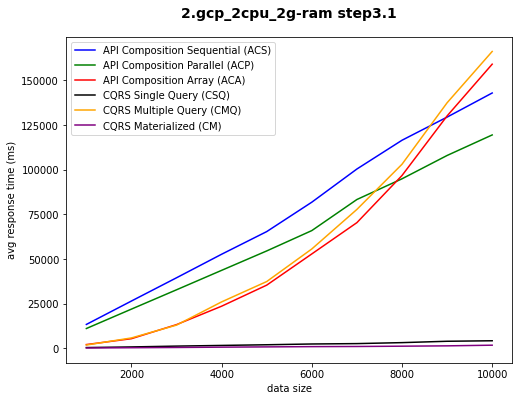

Tampilkan semua implementasi 

   sample  data_size            ACS            ACP            ACA          CSQ            CMQ           CM
0      10       1000   13297.639890   11011.890646    2022.369724   338.926914    1759.619589   109.834177
1      10       2000   26417.666792   21890.529004    5313.896583   692.123683    5736.753758   252.018051
2      10       3000   39442.138196   32710.421964   13199.214943  1154.179625   12923.141390   387.563173
3      10       4000   52626.202256   43602.206086   23516.391604  1537.789458   25935.450508   572.271352
4      10       5000   65312.784011   54476.700191   35316.437353  1914.083541   37331.398188   714.155595
5      10       6000   81786.183924   65872.549588   52800.953419  2342.445297   55586.517240   864.780805
6      10       7000  100370.747706   83285.378151   70332.230779  2562.426154   77737.879397   941.624414
7      10       8000  116476.554879   94881.743104   96727.491792  3105.254286  103030.201648  1110.630572
8     

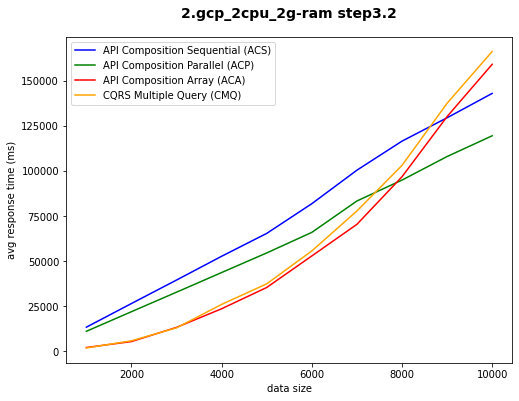

Detail implementasi ['ACS', 'ACP', 'ACA', 'CMQ']
ACA dan CMQ melampaui implementasi lainnya 

   sample  data_size            ACS            ACP            ACA            CMQ
0      10       1000   13297.639890   11011.890646    2022.369724    1759.619589
1      10       2000   26417.666792   21890.529004    5313.896583    5736.753758
2      10       3000   39442.138196   32710.421964   13199.214943   12923.141390
3      10       4000   52626.202256   43602.206086   23516.391604   25935.450508
4      10       5000   65312.784011   54476.700191   35316.437353   37331.398188
5      10       6000   81786.183924   65872.549588   52800.953419   55586.517240
6      10       7000  100370.747706   83285.378151   70332.230779   77737.879397
7      10       8000  116476.554879   94881.743104   96727.491792  103030.201648
8      10       9000  129445.252474  107945.185186  130100.983389  137471.600337
9      10      10000  142951.694994  119453.766445  159094.630530  166214.799587 



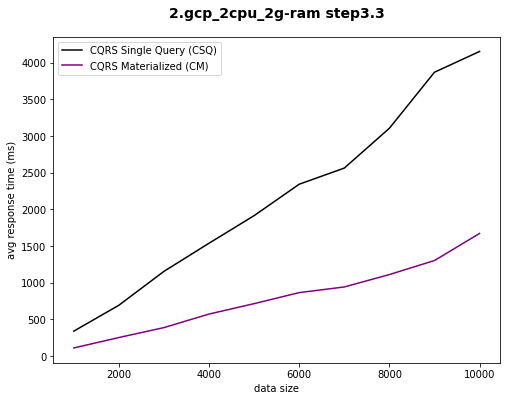

Detail implementasi ['CSQ', 'CM']
CSQ dan CM masilh menjadi implementasi dengan performa terbaik 

   sample  data_size          CSQ           CM
0      10       1000   338.926914   109.834177
1      10       2000   692.123683   252.018051
2      10       3000  1154.179625   387.563173
3      10       4000  1537.789458   572.271352
4      10       5000  1914.083541   714.155595
5      10       6000  2342.445297   864.780805
6      10       7000  2562.426154   941.624414
7      10       8000  3105.254286  1110.630572
8      10       9000  3869.126040  1302.193884
9      10      10000  4152.428895  1671.442073 




In [16]:
# Config about data visualization    
PC = PLOT_COLUMNS
configs = {
    '1.local_4cpu_8g-ram': {
        'step1': [
            {
                'cols': PC,
                'desc': '\n'.join([
                    f'Tampilkan semua implementasi\n',
                    f'Performa dari {PC[:2]} menurun signifikan dibandigkan yang lain',
                    f'Hal ini karena banyaknya request yang terjadi pada satu query relasional',
                    f'{PC[1]} memiliki performa lebih baik karena berjalan secara parallel',
                ])
            }, 
            {
                'cols': PC[2:], 
                'desc': '\n'.join([
                    f'Detail implementasi {PC[2:]}\n',
                    f'Performa {PC[2]} lebih lambat dari {PC[4]}, karena perlu request data ke service lain',
                    f'Performa {PC[3]} lebih baik dari {PC[4]} karena hanya perlu melakukan satu query database',
                ])
            }
        ],
        'step2': [
            {
                'cols': PC,
                'desc': 'Tampilkan semua implementasi'
            }, 
            {
                'cols': PC[2:],
                'desc': '\n'.join([
                    f'Detail implementasi {PC[2:]}',
                    f'Dapat dilihat bahwa {PC[2]} dan {PC[4]} mulai naik, karena iterasi pada loop semakin tinggi'
                ])
            }
        ],
        'step3': [
            {
                'cols': PC,
                'desc': 'Tampilkan semua implementasi',
            },
            {
                'cols': PC[:3]+[PC[4]],
                'desc': '\n'.join([
                    f'Detail implementasi {PC[:3]+[PC[4]]}',
                    f'{PC[2]} dan {PC[4]} naik signifikan dan melampaui {PC[1]}.'
                ])
            },
            {
                'cols': [PC[3],PC[5]],
                'desc': '\n'.join([
                    f'Detail implementasi {[PC[3],PC[5]]}',
                    f'{PC[3]} dan {PC[5]} memiliki performa terbaik (semakin kecil semakin bagus)'
                ])
            }
        ],
        'step4': [
            {
                'cols': PC,
                'desc': 'Tampilkan semua implementasi',
            },
            {
                'cols': PC[:3]+[PC[4]],
                'desc': '\n'.join([
                    f'Detail implementasi {PC[:3]+[PC[4]]}\n',
                    f'{PC[2]} dan {PC[4]} respon time tumbuh secara cepat melampaui semuanya\n',
                    f'{PC[4]} Mulai melampaui {PC[2]} secara stabil pada data_size > 6000',
                    f'Hal ini karena pada {PC[4]}, driver database perlu memformat beberapa tipe data seperti ObjectID sehingga membuat proses lebih lambat'
                ])
            },
            {
                'cols': PC[:3]+[PC[4]],
                'limit': { 'start': 0, 'end': 2},
                'desc': '\n'.join([
                    f'{PC[2]} dan {PC[4]} melampaui semuanya\n',
                    f'Hal ini diakibatkan oleh penggunaan loop pada compose data\n',
                    f'Berbeda dengan {PC[:2]}, meski juga menggunakan loop, namun juga ada kontirbusi indexing pada databse pada saat mencari data',
                ])
            },
            {
                'cols': [PC[3],PC[5]],
                'desc': '\n'.join([
                    f'Datail implementasi {[PC[3],PC[5]]}',
                    f'{PC[3]} dan {PC[5]} masih menjadi yang terbaik'
                ])
            }
        ]
    },
    '2.gcp_2cpu_2g-ram': {
        'step1': [
            {
                'cols': PC,
                'desc': '\n'.join([
                    f'Tampilkan semua implementasi\n',
                    f'Performa dari {PC[:2]} menurun signifikan dibandigkan yang lain',
                    f'Hal ini karena banyaknya request yang terjadi pada satu query relasional',
                    f'{PC[1]} memiliki performa lebih baik karena berjalan secara parallel',
                ])
            }, 
            {
                'cols': PC[2:], 
                'desc': '\n'.join([
                    f'Detail implementasi {PC[2:]}\n',
                    f'Performa {PC[2]} lebih lambat dari {PC[4]}, karena perlu request data ke service lain',
                    f'Performa {PC[3]} lebih baik dari {PC[4]} karena hanya perlu melakukan satu query database',
                ])
            }
        ],
        'step2': [
            {
                'cols': PC,
                'desc': 'Tampilkan semua implementasi'
            }, 
            {
                'cols': PC[2:],
                'desc': '\n'.join([
                    f'Detail implementasi {PC[2:]}',
                    f'Dapat dilihat bahwa {PC[2]} dan {PC[4]} mulai naik, karena iterasi pada loop semakin tinggi',
                    f'{PC[4]} juga mulai melampaui {PC[2]} akibat pengolahan langsung pada data hasil dari driver database (cost of abstraction)'
                ])
            }
        ],
        
        'step3': [
            {
                'cols': PC,
                'desc': 'Tampilkan semua implementasi',
            },
            {
                'cols': PC[:3]+[PC[4]],
                'desc': '\n'.join([
                    f'Detail implementasi {PC[:3]+[PC[4]]}',
                    f'{PC[2]} dan {PC[4]} melampaui implementasi lainnya'
                ])
            },
            {
                'cols': [PC[3],PC[5]],
                'desc': '\n'.join([
                    f'Detail implementasi {[PC[3],PC[5]]}',
                    f'{PC[3]} dan {PC[5]} masilh menjadi implementasi dengan performa terbaik'
                ])
            }
        ],
    }
}

print('Dalam test ini, semakin kecil response-time maka semakin cepat performanya')
visualize_result_path(RESULT_PATH, configs)

### Prediksi data (Bersifat Eksperimental dan Opsional)
Mencoba melakukan prediksi hasil response time berdasarkan dataset didapat dari hasil pengujian

**Argumen**

Prediksi ini digunakan untuk menggambarkan progress pada data size yang sangat besar karena proses pengujian pada data size > 1000 memakan waktu yang sangat lama bahkan berjam-jam

**NOTE**: 
- Hasil prediksi secara numerik belum tentu sesuai dengan data real hasil pengujian
- Hasil prediksi lebih ke menggambarkan bagaimana grow pada dari response pada data size yang lebih besar dari data size pada dataset
- Penerapan linear dan polynomial harus dilakukan secara hati-hati

In [12]:
import math
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression


def scaled(data):
    min_max_scaler = MinMaxScaler().fit(data)
    norm = min_max_scaler.transform(data)
    return norm

def build_poly_model(x: pd.Series, y: pd.Series):
    poly = PolynomialFeatures(include_bias=False)
    features = poly.fit_transform(x.to_numpy().reshape(-1, 1))
    model = LinearRegression()
    model.fit(features, y)
    return model

def predict_poly_range(model: LinearRegression, start: int, end: int, divide = 10):
    poly = PolynomialFeatures(include_bias=False)
    x = np.arange(start, end, math.floor(end-start)/divide)
    y = model.predict(poly.fit_transform(x.reshape(-1, 1)))
    return (x, y)

def build_linear_model(x: pd.Series, y: pd.Series):
    model = LinearRegression()
    model.fit(x.to_numpy().reshape(-1, 1), y)
    return model

def predict_linear_range(model: LinearRegression, start: int, end: int, divide = 10):
    x = np.arange(start, end, math.floor(end-start)/divide)
    y = model.predict(x.reshape(-1, 1))
    return (x, y)

def load_datasets_from_path(dataset_path=DATASET_PATH):
    dataset_files = [x for x in os.listdir(dataset_path) if 'skip' not in x]
    datasets = []
    for dataset_file in sorted(dataset_files):
        ds = get_locust_dataset_df(os.path.join(DATASET_PATH, dataset_file))
        datasets.append({'name': dataset_file, 'dataset': ds})
    return datasets

def load_datasets_from_result_path(result_path=RESULT_PATH):
    map = map_result_path_df(result_path)
    datasets = []
    for server, steps in map.items():
        ds = pd.DataFrame()
        for step, df in sorted(steps.items()):
            if df.empty:
                continue
            if ds.empty:
                ds = df.copy()
            else:
                ds = ds.append(df, ignore_index=True)
        datasets.append({'name': server, 'dataset': ds})
    return datasets

def get_prediction_from_range(ds, start, end, divide=None, predict_type=''):
    range = {'start': start, 'end': end, 'divide': divide if divide else end}
    df = pd.DataFrame()
    config = {
        PREDICT_LINEAR: { 'build_model_fn': build_linear_model,  'predict_fn': predict_linear_range},
        PREDICT_POLY: { 'build_model_fn': build_poly_model,  'predict_fn': predict_poly_range},
    }
    for i, (key, val) in enumerate(RESULT_MAP.items()):
        m = RESULT_MAP[key]
        conf = config[predict_type] if predict_type else config[m['predict_type']]
        model = conf['build_model_fn'](ds['data_size'], ds[key])
        x, y_predicted = conf['predict_fn'](model, **range)
        if df.empty:
            df['data_size'] = pd.Series(x)
        df[key] = pd.Series(y_predicted)
    return df

def visualize_datasets(map_ds, title='', ncols=2, figsize=(16, 6), columns=PLOT_COLUMNS,):
    nrows = math.ceil(len(map_ds.keys())/ncols)
    plt.figure(figsize=figsize)
    plt.suptitle(title, **plot_title_args, y=0.97)
    for i, (key, val) in enumerate(map_ds.items()):
        plt.subplot(nrows, ncols, i+1)
        for column in columns:
            if column in val.columns:
                m = RESULT_MAP[column]
                plt.plot(val['data_size'], val[column], color=m['color'], label = f"{m['name']} ({column})")
            plt.title(key)
            plt.xlabel('data size')
            plt.ylabel('avg response time (ms)')
            plt.legend()
    plt.show()

def visualize_dataset_each_method_prediction(
    y, 
    title,
    ncols=3, 
    ds=None, 
    figsize=(14,8), 
    ds_color='cyan', 
    plot_color=None,
    is_ds_scatter=True,
):
    nrows = math.ceil(len(RESULT_MAP.keys())/ncols)
    plt.figure(figsize=figsize)
    plt.suptitle(title, **plot_title_args, y=0.94)
    for i, (key, val) in enumerate(RESULT_MAP.items()):
        m = RESULT_MAP[key]
        plt.subplot(nrows, ncols, i+1)
        plt.title(f"{m['name']} ({key})")
        if ds is not None:    
            if is_ds_scatter:
                plt.scatter(ds['data_size'], ds[key], color=ds_color, label='dataset', s=2)
            else:
                plt.plot(ds['data_size'], ds[key], color=ds_color, label='dataset')
        color = plot_color if plot_color else m['color']
        plt.plot(y['data_size'], y[key], color=color, label="predicted")
        plt.legend()
    plt.show()

In [13]:
force_predict_type = "" #@param ["", "linear", "polynomial"]
predict_ds_source = "dataset" #@param ["dataset", "result"]

In [14]:
ds_path = {
    'dataset': { 'fn': load_datasets_from_path, 'path': DATASET_PATH }, 
    'result': { 'fn': load_datasets_from_result_path, 'path': RESULT_PATH }
}
src_ds = ds_path[predict_ds_source]

!tree {src_ds['path']} -I '*skip*'

/content/dataset
├── 1.local_4cpu_8g-ram_1-1000_step1.csv
└── 2.gcp_2cpu_2g-ram_1-1000_step1_i5.csv

0 directories, 2 files


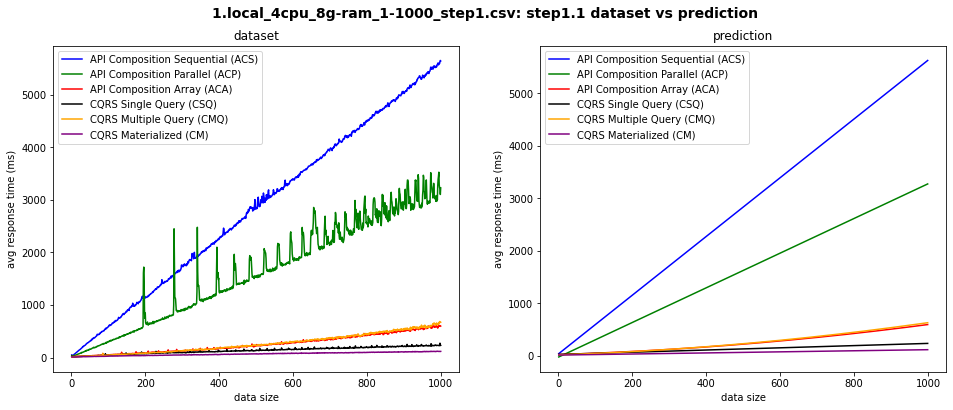

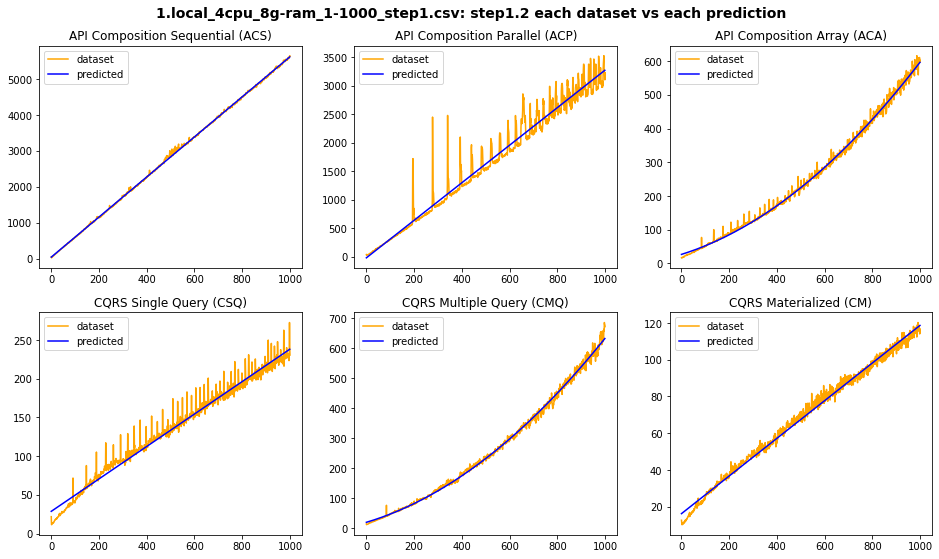

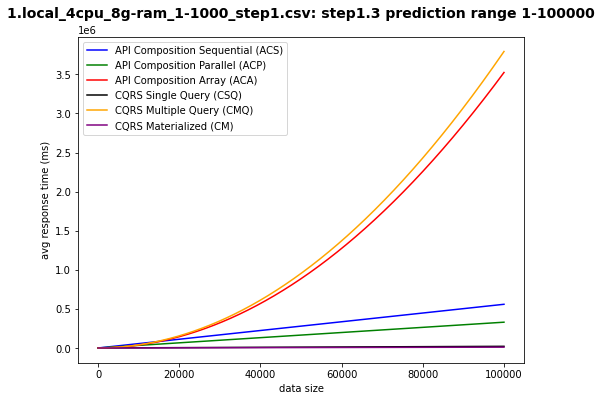

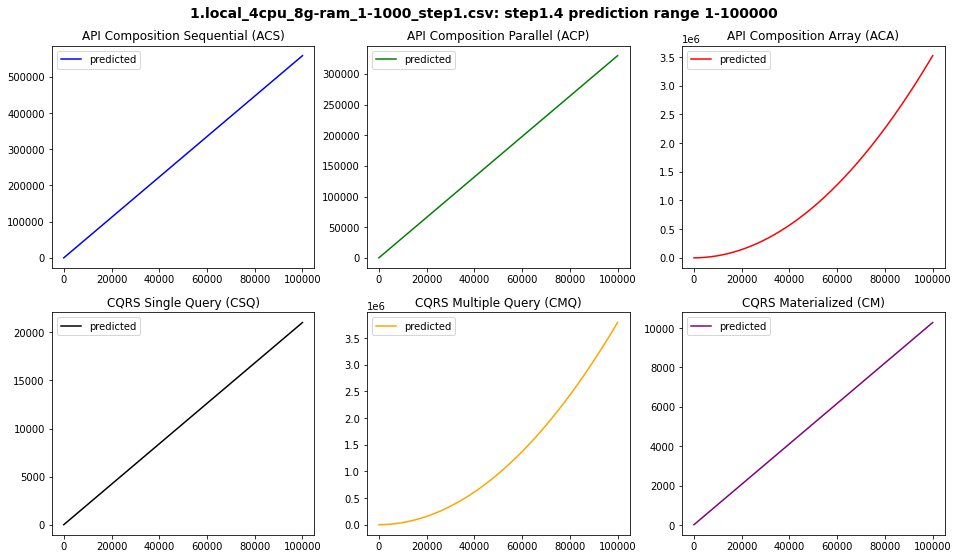

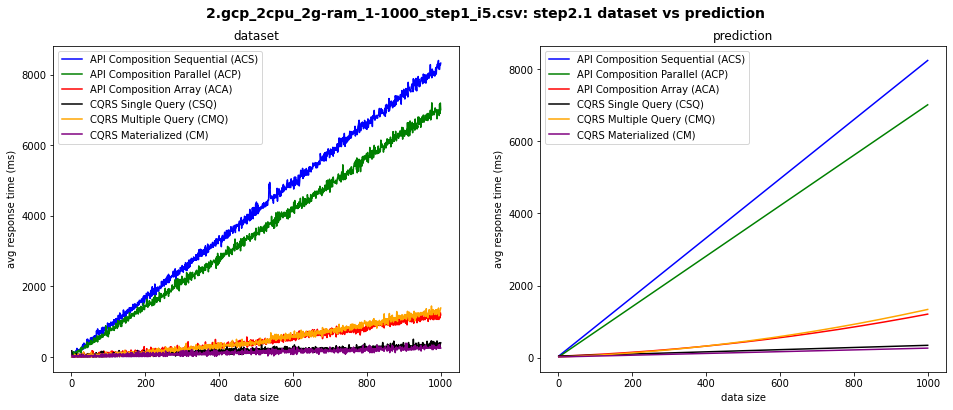

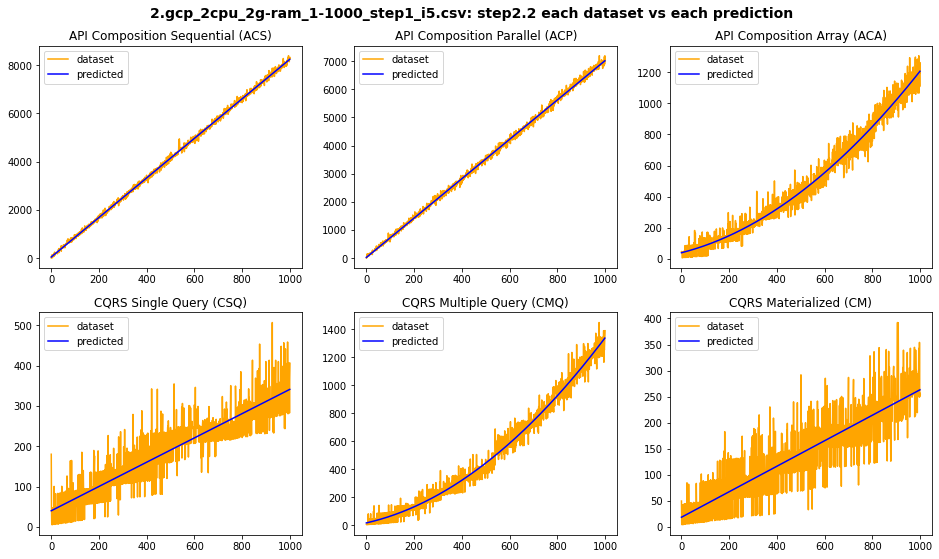

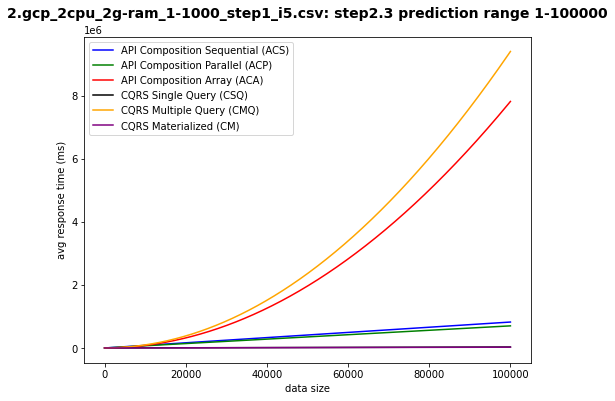

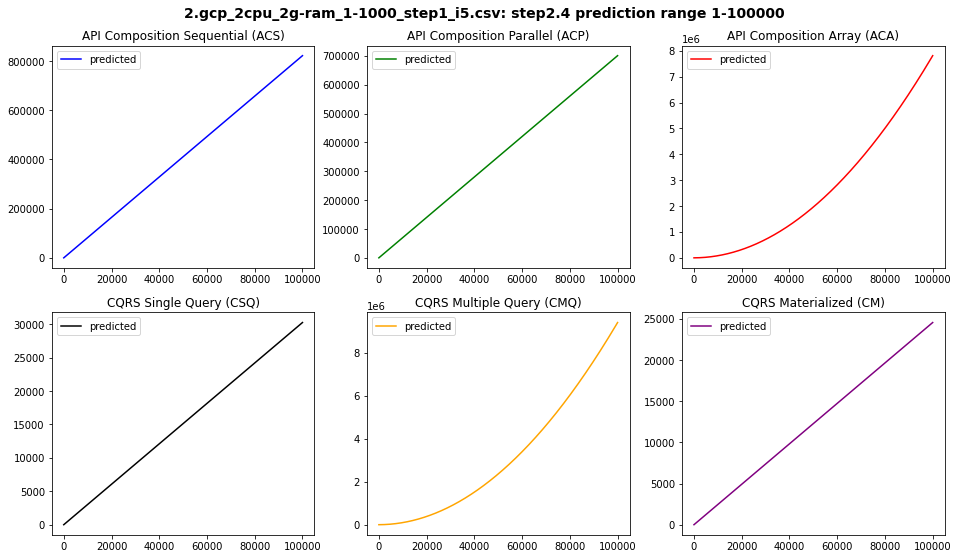

In [15]:
datasets = src_ds['fn'](src_ds['path'])

predict_args = {'start': 1, 'end': 100_000}
predict_type = force_predict_type

for i, data in enumerate(datasets):
    ds = data['dataset']
    name = data['name']
    viz_method_figsize = (16, 9)

    pred = get_prediction_from_range(
        ds, 
        start=ds['data_size'].min(), 
        end=ds['data_size'].max(), 
        predict_type=predict_type
    )
    visualize_datasets(
        {'dataset': ds, 'prediction': pred},
        title=f'{name}: step{i+1}.1 dataset vs prediction',
        ncols=2,
    )
    visualize_dataset_each_method_prediction(
        ds=ds, 
        y=pred, 
        ncols=3, 
        title=f'{name}: step{i+1}.2 each dataset vs each prediction', 
        figsize=viz_method_figsize,
        ds_color='orange',
        plot_color='blue',
        is_ds_scatter=False,
    )
    print('\n', end='')

    # prediction outside the dataset
    pred = get_prediction_from_range(ds, **predict_args, predict_type=predict_type)
    show_result_plot(pred, title=f'{name}: step{i+1}.3 prediction range {predict_args["start"]}-{predict_args["end"]}')
    visualize_dataset_each_method_prediction(
        y=pred, 
        ncols=3, 
        title=f'{name}: step{i+1}.4 prediction range {predict_args["start"]}-{predict_args["end"]}', 
        figsize=viz_method_figsize,
    )
    print('\n'*2, end='')

## Hasil
Berikut merupakan hasil dari pengujian pada berbagai implementasi 
- Pada perbandingan performa, secara general CQRS lebih cepat daripada API Composition ketika melakukan query data relasional karena kompleksitas flow data yang lebih rendah
- Jenis Implementasi juga mempengaruhi performa dari masing masing design-pattern/metode
- Jenis dan spesifikasi hardware juga mempengaruhi pada beberapa implementasi, misalnya pada API Compositoin Parallel akan lebih baik apabila didukung oleh banyak core CPU

### Faktor Utama Pengaruh Performa pada setiap Implementasi 
Pada tabel berikut **tidak** diurutkan berdasarkan performa yang terbaik atau terburuk

Implementasi | Faktor-faktor
---|---
API Composition Sequential | - Jumlah data (semakin banyak semakin lambat karena semakin banyak jumlah request yang dikirim)
API Composition Parallel | - Jumlah data (semakin banyak semakin lambat karena semakin banyak jumlah request yang dikirim)
    | - Spesifikasi hardware seperti jumlah Core-CPU dan replikasi service (semakin tinggi spesifikasi semakin baik)
API Compsition Array | - Jumlah data dan service yang terlibat relasi (semakin banyak, semakin lambat)
CQRS Single Query | - Satu query (aggregate) secara keseluruhan untuk query relasional dan membentuk data
CQRS Multiple Query | - Jumlah data dan tabel yang terlibat relasi (semakin banyak, semakin lambat)
    | - implementasi dari driver/library database (ORM/ODM sangat berpengaruh terutama pada data dalam jumlah sangat besar
CQRS Materialized | - Flow data sederhana (hanya operasi get data sederhana karena data sudah terbentuk seperti yang diinginkan)



### Rank Perbandingan Performa
Peforma diurutkan dari response-time yang tercepat ke yang terlambat

**Data Size 10-100 kelipatan 10**
- CQRS Materialized
- CQRS Single Query
- CQRS Multiple Query
- API Composition Array
- API Composition Parallel
- API Composition Sequential

**Data Size 100-1000 kelipatan 100**
- CQRS Materialized
- CQRS Single Query
- CQRS Multiple Query
- API Composition Array
- API Composition Parallel
- API Composition Sequential

**Data Size 1000-10.000 kelipatan 1000**
- CQRS Materialized
- CQRS Single Query
- CQRS Multiple Query
- API Composition Array
- API Composition Parallel
- API Composition Sequential

**Data Size 10.000-100.000 kelipatan 10.000**
- CQRS Materialized
- CQRS Single Query
- API Composition Parallel
- API Composition Sequential
- API Composition Array
- CQRS Multiple Query

### Rekomendasi
Mengingat kebutuhan request data dengan jumlah sangat tinggi cukup jarang ada di real-life karena biasanya akan meminimalkan jumlah data dalam satu kali request. Misalnya menggunakan pagination dan filter query untuk menemukan data yang tepat ( Google Search, Amazon Store)

Penulis menyimpulkan bahwa dari Rank Kompleksitas Flow data, Rank Kompleksitas implementasi, dan Rank Perbandingan Performa lebih awal cobalah untuk fokus di Implementasi API Composition dan Implementasi API Composition Array (dengan tetap mempertimbangakan jumlah data dan service yang terlibat dalam implementasi). Hal ini juga karena implementasi API Composition tidak sekompleks CQRS

Lalu ketika ada case yang perlu untuk performa yang sangat tinggi, dapat mempertimbangkan untuk implementasi CQRS Single Query karena performa yang ditawarkan cukup mendekati CQRS Materialized namun dengan dengan kompleksitas implementasi yang lebih rendah. CQRS Multiple Query juga dapat digunakan jika database tidak support single aggregate query seperti pada MongoDB namun coba jadikan CQRS Single Query sebagai opsi utama.

Sebisa mungkin hindari implementasi API Composition Sequential karena proses yang lama, kecuali untuk solusi sementara (misalnya tim service lain masih sibuk belum menyediakan API untuk filter data dengan ID array). 

Hindari juga API Composition Parallel karena implementasi ini cukup lambat, sangat bergantung pada spesifikasi hardware dan dapat menyebabkan server down jika tidak diimplementasi dengan benar (karena penggunaan resource berlebihan).

### Extras
Beberapa prinsip yang penulis gunakan untuk mengambil keputusan dalam menentukan rekomendasi

**YAGNI and KISS**

![](https://miro.medium.com/max/1007/0*qjP2M71XvThj869V)

[YAGNI by Martin Fowler](https://martinfowler.com/bliki/Yagni.html)

[YAGNI and KISS Principle](https://eugeniucozac.medium.com/yagni-kiss-principles-8274d5122457)


**Premature Optimization is Root of all Evil**

![premature optimization 1](https://i0.wp.com/www.clarkdever.com/wp-content/uploads/2019/03/C1NuQ8NWIAAAEAA.jpg?fit=600%2C338&ssl=1)

[Premature Optimization is Root of all Evil](https://stackify.com/premature-optimization-evil/#:~:text=Here%20is%20the%20full%20quote,of%20it)
